In [48]:
!pip install -U nltk

In [49]:
import pandas as pd
import re
import json
from nltk.corpus import stopwords
import nltk
import numpy as np
nltk.download('stopwords')

from nltk.util import pad_sequence
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# from google.colab import files
# uploaded = files.upload()

In [51]:
load_paths = ['../../data/train_data.csv', '../../data/valid_data.csv', '../../data/test_data.csv']
load_paths = ['./train_data.csv', './valid_data.csv', './test_data.csv']

train_data = pd.read_csv(load_paths[0])
valid_data = pd.read_csv(load_paths[1])
test_data = pd.read_csv(load_paths[2])

In [52]:
def filter_unwanted_rows(data):
    y = data['Label'].tolist()
    to_drop = [i for i in range(len(y)) if y[i] > 3]
    new_data = data.drop(labels=to_drop, axis=0)
    return np.asarray(new_data['Source']), np.asarray(new_data['Label'])

In [53]:
X_train, y_train = filter_unwanted_rows(train_data)
X_test, y_test = filter_unwanted_rows(test_data)
X_valid, y_valid = filter_unwanted_rows(valid_data)

In [54]:
from collections import Counter

print("Train labels ratio")
print(Counter(y_train.tolist()))
print("Test labels ratio")
print(Counter(y_test.tolist()))
print("Validation labels ratio")
print(Counter(y_valid.tolist()))

Train labels ratio
Counter({3: 14021, 2: 1942, 1: 65})
Test labels ratio
Counter({3: 3017, 2: 428, 1: 12})
Validation labels ratio
Counter({3: 3005, 2: 443, 1: 9})


In [55]:
# Different techniques for tackling class imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE

def balance_data(x, y, _type=0):
    if _type == 1:
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(x, y)
    elif _type == 2:
        smote = SMOTE()
        return smote.fit_resample(x, y)
    return x, y

In [56]:
from scipy.stats import pearsonr

def find_correlation(scores, y):
    corr, _ = pearsonr(scores, y)
    return corr

In [57]:
from math import log

def get_score(probabilities):
    if len(probabilities) == 0:
        return 0
    all_sent_scores = []
    for curr_sent_probabilities in probabilities:
        all_sent_scores.append(sum([log(p) for p in curr_sent_probabilities]) / len(curr_sent_probabilities))
    return sum(all_sent_scores) / len(all_sent_scores)

In [58]:
ValForGood = 0.5
ValForBad = 0.1
ValForGood_pos = 0.05
ValForBad_pos = 0.003

def get_improved_score(probabilities, is_pos=False):
    global ValForGood, ValForBad
    all_sent_scores = []
    for curr_sent_probabilities in probabilities:
        score = 1 / len(curr_sent_probabilities)
        for p in curr_sent_probabilities:
            if not is_pos:
                if p >= ValForGood or p <= ValForBad:
                    score *= p
            else:
                if p >= ValForGood_pos or p <= ValForBad_pos:
                    score *= p                
        all_sent_scores.append(score)
    return sum(all_sent_scores) / len(all_sent_scores)

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score, classification_report
import matplotlib.pyplot as plt
import json

statements = {0: "Without oversampling", 1: "With random oversampling", 2: "With SMOTE"}

def get_metrics(b, ytrue, ypred, file_name, folder_name):
    print('\n\n')
    print(statements[b] + '\n')
    print(classification_report(ytrue, ypred))
    ret = classification_report(ytrue, ypred, output_dict=True)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(f"{folder_name}/{file_name}_conf.png",dpi=300)
    plt.show()
    print('\n\n')
    with open(f"{folder_name}/{file_name}_stats.json", "w") as f:
        json.dump(ret, f, indent=4) 

In [60]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

n = 3
tokenized_data, num_ngrams, pos_tokenized_data = [], [], []

for text in X_train:
    current_text_details = [word_tokenize(sent.lower()) for sent in sent_tokenize(text)]
    pos_tokenized_data += [[t[1] for t in pos_tag(current_text_details[0])]]
    tokenized_data += current_text_details
    num_ngrams.append(sum([len(sent) + n - 1 for sent in current_text_details]))

num_ngrams = sorted(num_ngrams)
_d = {}
for i in range(5, 100, 5):
    _d[i] = num_ngrams[(i * len(num_ngrams)) // 100]
print("Cumulative Distribution of n-grams per data point (by %)")
print(_d)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Cumulative Distribution of n-grams per data point (by %)
{5: 23, 10: 26, 15: 27, 20: 28, 25: 30, 30: 31, 35: 33, 40: 34, 45: 35, 50: 37, 55: 38, 60: 40, 65: 42, 70: 43, 75: 45, 80: 47, 85: 49, 90: 52, 95: 54}


In [61]:
# LM training
train_data, padded_sents = padded_everygram_pipeline(n, tokenized_data)
model = MLE(n)
model.fit(train_data, padded_sents)

train_data, padded_sents = padded_everygram_pipeline(n, pos_tokenized_data)
pos_model = MLE(n)
pos_model.fit(train_data, padded_sents)

In [62]:
EPSILON = 1e-9
INF = 1e9
K = 12 # K frequent and K rarest n-gram probabilities of a sentence are considered as features

In [63]:
def compute_good_and_bad_thresholds(good_ratio=0.4, bad_ratio=0.2, is_pos=False):
    global X_train, model, pos_model
    _d = {}
    for x in X_train:
        sents = sent_tokenize(x)
        for sent in sents:
            words = word_tokenize(sent.lower())
            if is_pos:
                words = [t[1] for t in pos_tag(words)]
            curr_ngrams = list(ngrams(words, n=n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
            for ngram in curr_ngrams:
                if not is_pos:
                    _d[tuple(ngram)] = model.score(ngram[-1], ngram[:-1])
                else:
                    _d[tuple(ngram)] = pos_model.score(ngram[-1], ngram[:-1])
    probabilities = sorted(_d.values())
    print(probabilities)
    ValForGood = probabilities[int((1 - good_ratio)*len(probabilities))]
    ValForBad = probabilities[int(bad_ratio*len(probabilities))]
    return ValForGood, ValForBad

print(compute_good_and_bad_thresholds(is_pos=True))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [64]:
def get_all_ngram_probabilities(given_text, is_pos=False):
    global model, INF, n
    text = given_text.lower()
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return [], INF
    all_ngram_probabilities, all_perplexities = [], []
    for sent in sentences:
        words = word_tokenize(sent)
        if is_pos:
            words = [t[1] for t in pos_tag(words)]
        curr_ngrams = list(ngrams(words, n=n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
        if not is_pos:
            all_ngram_probabilities.append([max(EPSILON, model.score(ngram[-1], ngram[:-1])) for ngram in curr_ngrams])
            perplexity = model.perplexity(curr_ngrams)
        else:
            all_ngram_probabilities.append([max(EPSILON, pos_model.score(ngram[-1], ngram[:-1])) for ngram in curr_ngrams])
            perplexity = pos_model.perplexity(curr_ngrams)            
        if perplexity == 'inf':
            perplexity = INF
        all_perplexities.append(perplexity)
    return all_ngram_probabilities, sum(all_perplexities) / len(all_perplexities)

In [65]:
def get_feature_vector(text):
    global K
    features = []
    for is_pos in [False, True]:
        all_ngram_probabilities, perplexity = get_all_ngram_probabilities(text, is_pos=is_pos) 
        all_ngram_probabilities = sorted(sum(all_ngram_probabilities, []))
        if len(all_ngram_probabilities) == 0:
            return [0 for _ in range(2*K)] + [INF]
        frequent_k, rarest_k = all_ngram_probabilities[-K:], all_ngram_probabilities[:K]
        if len(frequent_k) < K:
            median = frequent_k[len(frequent_k) // 2]
            for _ in range(K - len(frequent_k)):
                frequent_k.append(median)
            frequent_k = sorted(frequent_k)
        if len(rarest_k) < K:
            median = rarest_k[len(rarest_k) // 2]
            for _ in range(K - len(rarest_k)):
                rarest_k.append(median)
            rarest_k = sorted(rarest_k)
        features = features + frequent_k + rarest_k + [perplexity]
    return features

In [66]:
from sklearn.linear_model import LogisticRegression

# Training on train set, testing on both validation and test sets - 70:30
train_features, train_labels, test_features, test_labels = [], [], [], []
scores, improved_scores, pos_scores, pos_improved_scores = [], [], [], []

for i in range(len(X_train)):
    features = get_feature_vector(X_train[i])
    train_features.append(features)
    train_labels.append(y_train[i])
    scores.append(get_score(get_all_ngram_probabilities(X_train[i])[0]))
    pos_scores.append(get_score(get_all_ngram_probabilities(X_train[i], is_pos=True)[0]))
    improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_train[i])[0]))
    pos_improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_train[i], is_pos=True)[0], is_pos=True))

for i in range(len(X_test)):
    features = get_feature_vector(X_test[i])
    test_features.append(features)
    test_labels.append(y_test[i])
    scores.append(get_score(get_all_ngram_probabilities(X_test[i])[0]))
    pos_scores.append(get_score(get_all_ngram_probabilities(X_test[i], is_pos=True)[0]))
    improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_test[i])[0]))
    pos_improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_test[i], is_pos=True)[0], is_pos=True))

for i in range(len(X_valid)):
    features = get_feature_vector(X_valid[i])
    test_features.append(features)
    test_labels.append(y_valid[i])
    scores.append(get_score(get_all_ngram_probabilities(X_valid[i])[0]))
    pos_scores.append(get_score(get_all_ngram_probabilities(X_valid[i], is_pos=True)[0]))
    improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_valid[i])[0]))
    pos_improved_scores.append(get_improved_score(get_all_ngram_probabilities(X_valid[i], is_pos=True)[0], is_pos=True))

In [67]:
# Calculating correlations for various scores
print(len(scores), len(train_labels + test_labels))
print("Correlation between score and labels: ", find_correlation(scores, train_labels + test_labels))
print("Correlation between improved score and labels: ", find_correlation(improved_scores, train_labels + test_labels))
print("Correlation between POS score and labels: ", find_correlation(pos_scores, train_labels + test_labels))
print("Correlation between POS improved score and labels: ", find_correlation(pos_improved_scores, train_labels + test_labels))

22942 22942
Correlation between score and labels:  0.011393573108917752
Correlation between improved score and labels:  -0.012521626847872912
Correlation between POS score and labels:  0.02466264917029516
Correlation between POS improved score and labels:  -0.009542725672286074


[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004677268475210477, 0.00974025974025974, 0.011602028530774564, 0.034482758620689655, 0.048600883652430045, 0.04918032786885246, 0.04954576963771024, 0.0660377358490566, 0.08536585365853659, 0.0933852140077821, 0.10344827586206896, 0.25, 3.0612432800590046, 0.2990961380443714, 0.30256410256410254, 0.31307478954795387, 0.33554376657824936, 0.4247546346782988, 0.5181744749596123, 0.5227367792052584, 0.8112509252405625, 0.9166666666666666, 0.9649188514357053, 1.0, 1.0, 0.006395614435815441, 0.009360718022135344, 0.03346681922196797, 0.034653465346534656, 0.040224508886810104, 0.04329004329004329, 0.04476625736468256, 0.047042675318193165, 0.05983279261292738, 0.06361031518624642, 0.06818181818181818, 0.0713220675944334, 6.510183755963828], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004037685060565276, 0.004178272980501393, 0.008928571428571428, 0.027107884271589625, 0.03333333333333333, 0.05357142857142857,

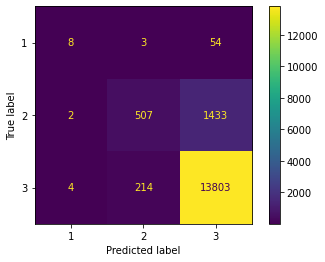





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.11      0.05      0.07        21
           2       0.17      0.07      0.10       871
           3       0.87      0.95      0.91      6022

    accuracy                           0.83      6914
   macro avg       0.38      0.36      0.36      6914
weighted avg       0.78      0.83      0.80      6914



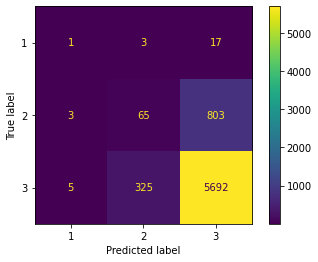




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004677268475210477, 0.00974025974025974, 0.011602028530774564, 0.034482758620689655, 0.048600883652430045, 0.04918032786885246, 0.04954576963771024, 0.0660377358490566, 0.08536585365853659, 0.0933852140077821, 0.10344827586206896, 0.25, 3.0612432800590046, 0.2990961380443714, 0.30256410256410254, 0.31307478954795387, 0.33554376657824936, 0.4247546346782988, 0.5181744749596123, 0.5227367792052584, 0.8112509252405625, 0.9166666666666666, 0.9649188514357053, 1.0, 1.0, 0.006395614435815441, 0.009360718022135344, 0.03346681922196797, 0.034653465346534656, 0.040224508886810104, 0.04329004329004329, 0.04476625736468256, 0.047042675318193165, 0.05983279261292738, 0.06361031518624642, 0.06818181818181818, 0.07132206759443

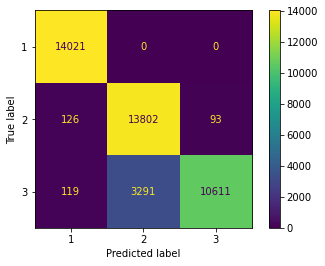





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.02      0.05      0.02        21
           2       0.14      0.26      0.18       871
           3       0.88      0.76      0.81      6022

    accuracy                           0.69      6914
   macro avg       0.34      0.35      0.34      6914
weighted avg       0.78      0.69      0.73      6914



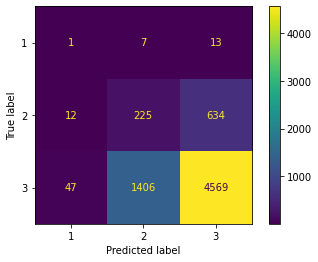




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.004677268475210477, 0.00974025974025974, 0.011602028530774564, 0.034482758620689655, 0.048600883652430045, 0.04918032786885246, 0.04954576963771024, 0.0660377358490566, 0.08536585365853659, 0.0933852140077821, 0.10344827586206896, 0.25, 3.0612432800590046, 0.2990961380443714, 0.30256410256410254, 0.31307478954795387, 0.33554376657824936, 0.4247546346782988, 0.5181744749596123, 0.5227367792052584, 0.8112509252405625, 0.9166666666666666, 0.9649188514357053, 1.0, 1.0, 0.006395614435815441, 0.009360718022135344, 0.03346681922196797, 0.034653465346534656, 0.040224508886810104, 0.04329004329004329, 0.04476625736468256, 0.047042675318193165, 0.05983279261292738, 0.06361031518624642, 0.06818181818181818, 0.07132206759443

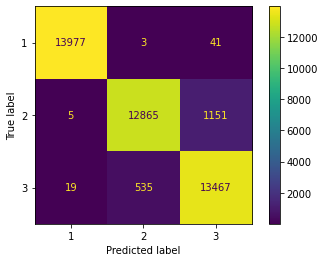





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.04      0.05      0.04        21
           2       0.16      0.13      0.14       871
           3       0.88      0.90      0.89      6022

    accuracy                           0.80      6914
   macro avg       0.36      0.36      0.36      6914
weighted avg       0.78      0.80      0.79      6914



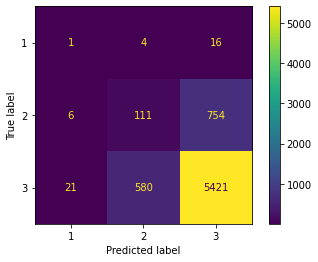




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [74]:
# RF
from sklearn.ensemble import RandomForestClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    rf_model = RandomForestClassifier(random_state=123).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = rf_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"RF_train_{t}", "RF")
    print("\nFor test set\n")
    test_pred = rf_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"RF_test_{t}", "RF")
    print('-'*210)

Class distribution: Counter({3: 14021, 2: 1942, 1: 65})

For training set




Without oversampling

              precision    recall  f1-score   support

           1       0.49      0.32      0.39        65
           2       0.61      0.42      0.50      1942
           3       0.92      0.96      0.94     14021

    accuracy                           0.89     16028
   macro avg       0.67      0.57      0.61     16028
weighted avg       0.88      0.89      0.88     16028



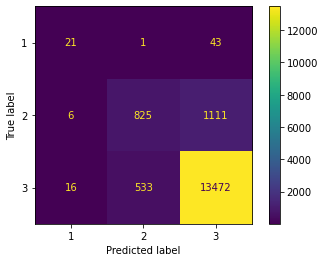





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.03      0.05      0.04        21
           2       0.16      0.16      0.16       871
           3       0.88      0.87      0.87      6022

    accuracy                           0.78      6914
   macro avg       0.35      0.36      0.36      6914
weighted avg       0.78      0.78      0.78      6914



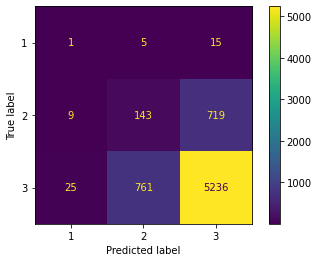




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With random oversampling

              precision    recall  f1-score   support

           1       0.98      1.00      0.99     14021
           2       0.81      0.99      0.89     14021
           3       1.00      0.75      0.86     14021

    accuracy                           0.91     42063
   macro avg       0.93      0.91      0.91     42063
weighted avg       0.93      0.91      0.91     42063



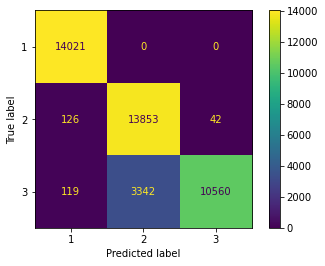





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.02      0.05      0.02        21
           2       0.14      0.26      0.18       871
           3       0.88      0.75      0.81      6022

    accuracy                           0.69      6914
   macro avg       0.34      0.35      0.34      6914
weighted avg       0.78      0.69      0.73      6914



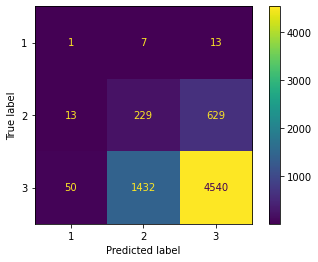




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With SMOTE

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     14021
           2       0.95      0.92      0.94     14021
           3       0.92      0.95      0.94     14021

    accuracy                           0.96     42063
   macro avg       0.96      0.96      0.96     42063
weighted avg       0.96      0.96      0.96     42063



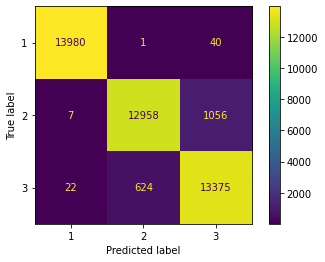





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.02      0.05      0.03        21
           2       0.16      0.16      0.16       871
           3       0.88      0.87      0.87      6022

    accuracy                           0.78      6914
   macro avg       0.35      0.36      0.35      6914
weighted avg       0.78      0.78      0.78      6914



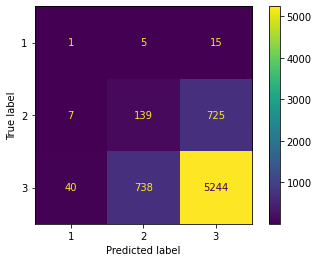




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [75]:
# DT
from sklearn.tree import DecisionTreeClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    dt_model = DecisionTreeClassifier(random_state=123).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = dt_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"DT_train_{t}", "DT")
    print("\nFor test set\n")
    test_pred = dt_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"DT_test_{t}", "DT")
    print('-'*210)

Class distribution: Counter({3: 14021, 2: 1942, 1: 65})

For training set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00      1942
           3       0.87      1.00      0.93     14021

    accuracy                           0.87     16028
   macro avg       0.29      0.33      0.31     16028
weighted avg       0.77      0.87      0.82     16028



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

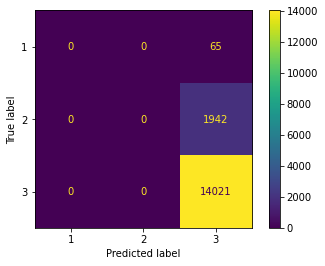





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       871
           3       0.87      1.00      0.93      6022

    accuracy                           0.87      6914
   macro avg       0.29      0.33      0.31      6914
weighted avg       0.76      0.87      0.81      6914



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

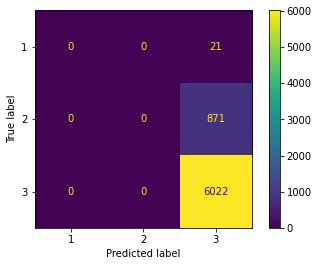




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With random oversampling

              precision    recall  f1-score   support

           1       0.61      0.98      0.75     14021
           2       0.56      0.39      0.46     14021
           3       0.55      0.38      0.45     14021

    accuracy                           0.58     42063
   macro avg       0.57      0.58      0.55     42063
weighted avg       0.57      0.58      0.55     42063



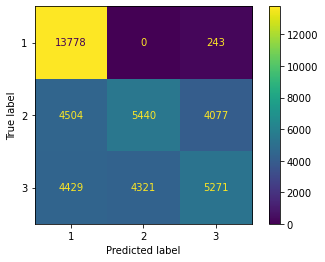





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.00      0.29      0.01        21
           2       0.14      0.35      0.20       871
           3       0.88      0.35      0.51      6022

    accuracy                           0.35      6914
   macro avg       0.34      0.33      0.24      6914
weighted avg       0.78      0.35      0.46      6914



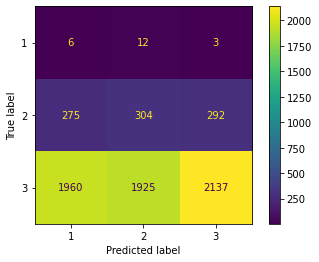




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With SMOTE

              precision    recall  f1-score   support

           1       0.57      0.98      0.72     14021
           2       0.55      0.49      0.52     14021
           3       0.61      0.24      0.34     14021

    accuracy                           0.57     42063
   macro avg       0.58      0.57      0.53     42063
weighted avg       0.58      0.57      0.53     42063



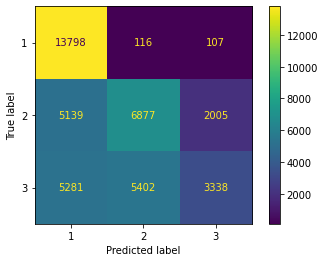





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.33      0.01        21
           2       0.13      0.41      0.20       871
           3       0.88      0.24      0.38      6022

    accuracy                           0.26      6914
   macro avg       0.34      0.33      0.19      6914
weighted avg       0.78      0.26      0.35      6914



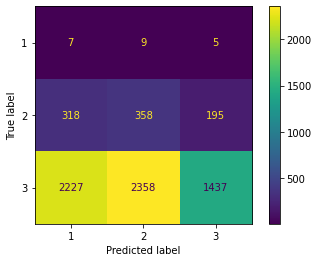




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [76]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    knn_model = KNeighborsClassifier(n_neighbors=203).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = knn_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"KNN_train_{t}", "KNN")
    print("\nFor test set\n")
    test_pred = knn_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"KNN_test_{t}", "KNN")
    print('-'*210)

Class distribution: Counter({3: 14021, 2: 1942, 1: 65})

For training set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00      1942
           3       0.87      1.00      0.93     14021

    accuracy                           0.87     16028
   macro avg       0.29      0.33      0.31     16028
weighted avg       0.77      0.87      0.82     16028



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

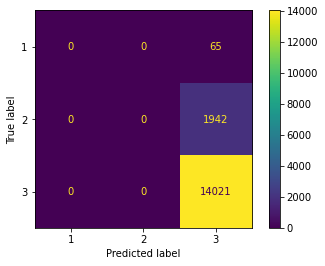





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       871
           3       0.87      1.00      0.93      6022

    accuracy                           0.87      6914
   macro avg       0.29      0.33      0.31      6914
weighted avg       0.76      0.87      0.81      6914



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

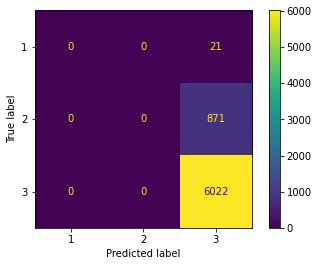




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With random oversampling

              precision    recall  f1-score   support

           1       0.38      0.14      0.20     14021
           2       0.52      0.01      0.02     14021
           3       0.34      0.88      0.49     14021

    accuracy                           0.34     42063
   macro avg       0.41      0.34      0.24     42063
weighted avg       0.41      0.34      0.24     42063



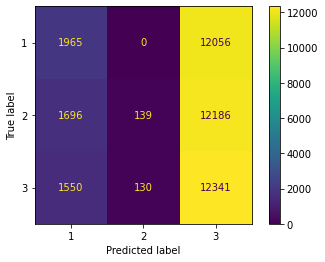





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.00      0.10      0.00        21
           2       0.14      0.03      0.05       871
           3       0.87      0.85      0.86      6022

    accuracy                           0.75      6914
   macro avg       0.34      0.32      0.30      6914
weighted avg       0.78      0.75      0.76      6914



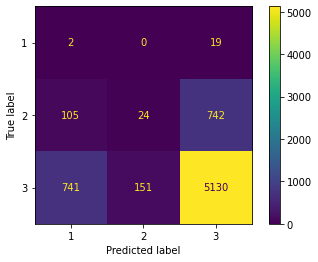




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Class distribution: Counter({3: 14021, 2: 14021, 1: 14021})

For training set




With SMOTE

              precision    recall  f1-score   support

           1       0.40      0.14      0.20     14021
           2       0.58      0.01      0.03     14021
           3       0.34      0.89      0.49     14021

    accuracy                           0.35     42063
   macro avg       0.44      0.35      0.24     42063
weighted avg       0.44      0.35      0.24     42063



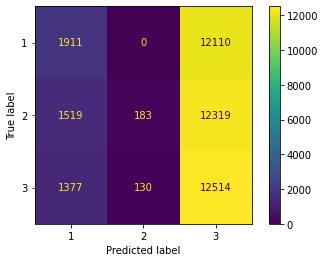





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.10      0.01        21
           2       0.14      0.03      0.05       871
           3       0.87      0.88      0.87      6022

    accuracy                           0.77      6914
   macro avg       0.34      0.33      0.31      6914
weighted avg       0.78      0.77      0.77      6914



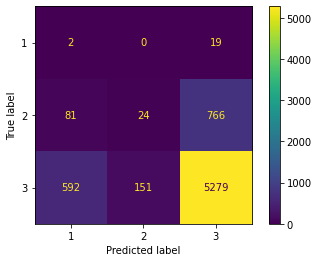




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [78]:
# SVM
from sklearn import svm

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    svm_model = svm.SVC().fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = svm_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"SVM_train_{t}", "SVM")
    print("\nFor test set\n")
    test_pred = svm_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"SVM_test_{t}", "SVM")
    print('-'*210)

In [79]:
!zip -r SVM.zip SVM
!zip -r DT.zip DT
!zip -r RF.zip RF
!zip -r KNN.zip KNN

  adding: SVM/ (stored 0%)
  adding: SVM/SVM_train_0_stats.json (deflated 72%)
  adding: SVM/SVM_train_1_conf.png (deflated 14%)
  adding: SVM/SVM_test_0_stats.json (deflated 71%)
  adding: SVM/SVM_train_0_conf.png (deflated 19%)
  adding: SVM/SVM_train_2_stats.json (deflated 69%)
  adding: SVM/SVM_test_1_stats.json (deflated 66%)
  adding: SVM/SVM_test_0_conf.png (deflated 19%)
  adding: SVM/SVM_test_1_conf.png (deflated 18%)
  adding: SVM/SVM_test_2_stats.json (deflated 66%)
  adding: SVM/SVM_train_1_stats.json (deflated 68%)
  adding: SVM/SVM_test_2_conf.png (deflated 17%)
  adding: SVM/SVM_train_2_conf.png (deflated 16%)
  adding: DT/ (stored 0%)
  adding: DT/DT_test_2_conf.png (deflated 18%)
  adding: DT/DT_train_0_conf.png (deflated 18%)
  adding: DT/DT_test_1_stats.json (deflated 66%)
  adding: DT/DT_test_1_conf.png (deflated 19%)
  adding: DT/DT_train_2_stats.json (deflated 71%)
  adding: DT/DT_test_0_conf.png (deflated 19%)
  adding: DT/DT_train_1_conf.png (deflated 16%)
  add

In [80]:
from google.colab import files
files.download("SVM.zip")
files.download("DT.zip")
files.download("RF.zip")
files.download("KNN.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>